In [0]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
drive_path = '/content/drive/My Drive/Colab Notebooks/SDC_P4/'
# drive_path = '/opt/carnd_p3/' # path on udacity workspace GPU mode

In [0]:
# !pip install keras==2.2.4
!pip show keras  # 2.2.4 for Udacity workspace, 2.2.5 is default by Google Colab

Name: Keras
Version: 2.2.5
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, six, scipy, keras-applications, keras-preprocessing, pyyaml, h5py
Required-by: 


In [0]:
import os
import csv
import cv2
import numpy as np
import pandas as pd

In [0]:
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Cropping2D


### Prepare data set

In [0]:
df2 = pd.read_csv(drive_path + 'data/driving_log.csv')
# reduce similar training data, particularly to reduce steering angle =0 by a factor of 8
df3 = df2.loc[df2['steering']!=0]; 
df4 = df2.loc[df2['steering']==0][::8]; 
df = pd.concat([df3, df4])
# df = df2
# df = df0.head(500)  # small sample size to check code
imgName = df[['center', 'left', 'right']].values
angle = df['steering'].values

for i in range(0, len(imgName)):
  imgName[i][1] = imgName[i][1][1:]
  imgName[i][2] = imgName[i][2][1:]

# Split the data
X_trainfname, X_validfname, y_trainang, y_validang = train_test_split(imgName, angle, test_size=0.2, shuffle= True)
TrainSize = len(X_trainfname); 
ValidSize = len(X_validfname); 

In [0]:
print("Training Sample Size = ", TrainSize)
print("Validation Sample Size = ",ValidSize)
print("All Sample Size = ", len(df))

Training Sample Size =  3376
Validation Sample Size =  845
All Sample Size =  4221


[   4    2    3    4   17   66  111  250  447  761 1188  671  379  185
   86   33    7    4    1    0    2]
[-0.9426954  -0.8501861  -0.75767679 -0.66516749 -0.57265818 -0.48014888
 -0.38763957 -0.29513027 -0.20262096 -0.11011166 -0.01760235  0.07490695
  0.16741626  0.25992556  0.35243487  0.44494417  0.53745348  0.62996278
  0.72247209  0.81498139  0.9074907   1.        ]


<function matplotlib.pyplot.show>

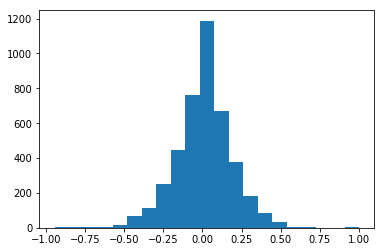

In [0]:
# Visualize data size for triming
hist, bins2 = np.histogram(angle, 21)
print(hist)
print(bins2)


# need input matplot lib
import matplotlib.pyplot as plt
plt.hist(angle,bins = bins2)
plt.show


### Data Generator

In [0]:
def aug_flip(images, angles):
    augflip_img = []
    augflip_ang = []
    for (img, ang) in zip(images, angles):
      augflip_img.append(img)
      augflip_ang.append(ang)
      augflip_img.append(np.fliplr(img))  #augflip_img.append(cv2.flip(img, 1))
      augflip_ang.append(ang*(-1.0))        
    return np.array(augflip_img), np.array(augflip_ang)

In [0]:
def generator(X_trainfname, y_trainang, batch_size=32):
    num_samples = len(y_trainang)
    while 1: # Loop forever so the generator never terminates

        for offset in range(0, num_samples, batch_size):
            batch_imgName = X_trainfname[offset:offset+batch_size]
            batch_angle = y_trainang[offset:offset+batch_size]

            images = []
            angles = []
            for k in range(0,len(batch_angle)):
              for j in range(0,3):
                name = drive_path + 'data/' + batch_imgName[k][j]
                #print(name)
                image_bgr = cv2.imread(name)
                image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
                if image_rgb is None:
                  continue  
                else:
                  steer_angle = float(batch_angle[k])
                  if j == 1:
                    steer_angle = steer_angle+0.2
                  elif j ==2:
                    steer_angle = steer_angle-0.2

                  images.append(image_rgb)
                  angles.append(steer_angle)
            # call pre-process - flipping
            augflip_img, augflip_ang = aug_flip(images, angles)
            yield shuffle(np.array(augflip_img), np.array(augflip_ang))
            
train_generator= generator(X_trainfname, y_trainang)
validation_generator= generator(X_validfname, y_validang)    

### Build Model

In [0]:
model = Sequential()
model.add(Lambda(lambda x: x/127.5-1.0, input_shape=(160,320,3)))
model.add(Cropping2D(cropping = ((60,25),(0,0)))) # 60 pixels from the top and 25 pixels from the bottom. ((top_crop, bottom_crop), (left_crop, right_crop))
model.add(Conv2D(24, (5, 5), activation='elu', strides=(2, 2)))
model.add(Conv2D(36, (5, 5), activation='elu', strides=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(48, (5, 5), activation='elu', strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_3 (Cropping2D)    (None, 75, 320, 3)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 36, 158, 24)       1824      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 77, 36)        21636     
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 77, 36)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 6, 37, 48)         43248     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 35, 64)        

In [0]:
batch_size=32
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, 
            steps_per_epoch = TrainSize//batch_size, 
            validation_data = validation_generator, 
            validation_steps = ValidSize//batch_size, 
            epochs = 5, verbose = 1)
model.save(drive_path + 'Build-model-09.h5')

Epoch 1/5
 34/105 [========>.....................] - ETA: 25:27 - loss: 0.1530

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:709: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


105/105 [==============================] - 2675s 25s/step - loss: 0.0788 - val_loss: 0.0312
Epoch 2/5
105/105 [==============================] - 130s 1s/step - loss: 0.0348 - val_loss: 0.0253
Epoch 3/5
105/105 [==============================] - 130s 1s/step - loss: 0.0301 - val_loss: 0.0242
Epoch 4/5
105/105 [==============================] - 131s 1s/step - loss: 0.0276 - val_loss: 0.0218
Epoch 5/5
105/105 [==============================] - 128s 1s/step - loss: 0.0262 - val_loss: 0.0216


dict_keys(['val_loss', 'loss'])


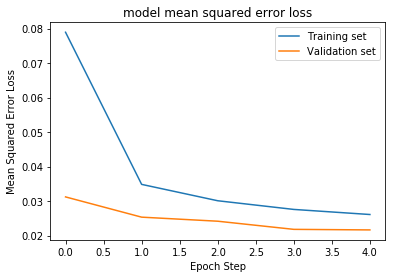

In [0]:
print(history_object.history.keys())

### plot the training and validation loss for each epoch
import matplotlib.pyplot as plt
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('Mean Squared Error Loss')
plt.xlabel('Epoch Step')
plt.legend(['Training set', 'Validation set'], loc='best')
plt.show()